## Imoprting Libraries

We will start with importing necessary libraries

In [1]:
# Importing different libraries for processing
import math
import os

import itertools

# For graph plotting
import matplotlib.pyplot as plt
import pandas as pd
import scipy

import cv2 #Library for image processing functions
from PIL import Image # PIL is another python image library (PIL)
import numpy as np # For dealing with multi dimensional arrays

# Importing Keras libarary for deep learning
from keras import layers
from keras.applications import ResNet50 # Importing pre-trained ResNet model
from keras.utils.np_utils import to_categorical # For one hot encoding of label vector
from keras.models import Sequential
from keras.optimizers import Adam # Adam is a type of gradient descent optimizer
from sklearn.model_selection import train_test_split # For splitting the dataset into training and testing sets
from sklearn.metrics import accuracy_score # Importing some accuracy metrics
from tqdm import tqdm # Library for showing progress bar when loading images, https://pypi.org/project/tqdm/
from keras import backend as K
import tensorflow as tf # Importing tensorflow as well

device_name = tf.test.gpu_device_name() # Selecting GPU for model training

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

%matplotlib inline

Found GPU at: /device:GPU:0


## Importing the dataset
### Accessing the dataset on google drive

The dataset was upload on Google drive and was processed in Google Colab.

In [2]:
#Mounting the google drive so that the dataset uploaded on it can be accessed in Colab

from google.colab import drive

drive.mount("/content/gdrive")

!ls "/content/gdrive/My Drive/brain_tumor_dataset"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
no  yes


### Loading the dataset

In [4]:
# A function to load set of images from a directory
def Dataset_loader(DIR, RESIZE):
    IMG = [] # A list in which we will add/append the images of the dataset

    for IMAGE_NAME in tqdm(os.listdir(DIR)): #Loop through the all of the filenames present in the DIR, tqdm is for showing the progress bar
        PATH = os.path.join(DIR,IMAGE_NAME) #IMAGE_NAME contains the name of one image file for the for loop iteration, we will joing the filename with the directory path
        _, ftype = os.path.splitext(PATH) # to get the file type of the loaded file (file type such as .png, .doc)
        if ftype == ".jpg": # to process only .JPG file type
            img = np.asarray(Image.open(PATH).convert("RGB")) # Open the image, convert it to a RGB, 3 channel numpy array
            img = cv2.resize(img, (RESIZE,RESIZE)) # resize the image
            IMG.append(np.array(img)) # append the loaded list to the list IMD defined outside the loop

    return IMG # return the IMG list containg the arrays of images loaded through the for loop

path = "/content/gdrive/My Drive/brain_tumor_dataset/" # Path where the dataset is stored
benign_data = np.array(Dataset_loader(path+'no',IMAGE_RESIZE)) 
malign_data = np.array(Dataset_loader(path+'yes',IMAGE_RESIZE))

# Print our the number of images in each dataset
print("Total images in the benign dataset: ", len(benign_data))
print("Total images in the malign dataset: ", len(malign_data))

100%|██████████| 155/155 [00:00<00:00, 329.24it/s]

Total images in the benign dataset:  85
Total images in the malign dataset:  86


## Hyper parameters
The hyper parameters are defined here

In [3]:
# All hyper parameters
IMAGE_RESIZE = 224 #224 is the input to various CNN archs (Transfer Learning)
num_classes= 2
BATCH_SIZE = 16 # batch size tell us the no of images process at once through our model when training
lr=1e-4 #Learning rate used in Adam (Gradient Descent) optimizer
epochs=10 # total number of epochs


## Creating Label

Now, we will create lables for the loaded images. Since, this is a binary classification problem (tumor is present or not), we will create two binary labels. 

After the label creation, the two datasets (malign data and benign data) are merged, and then shuffled. After that, the label vector is one hot encoded. 

In [5]:
# Skin Cancer: Malignant vs. Benign

# Create labels
benign_data_label = np.zeros(len(benign_data)) #Using 0 for BENIGN
malign_data_label = np.ones(len(malign_data)) # Using 1 for MALIGN

# Merging data 
X_data = np.concatenate((benign_data, malign_data), axis = 0)
Y_data = np.concatenate((benign_data_label, malign_data_label), axis = 0)

# Shuffling data
s = np.arange(X_data.shape[0])
np.random.shuffle(s)
X_data = X_data[s]
Y_data = Y_data[s]

# One hot encoding the label vector
Y_data = to_categorical(Y_data, num_classes)

## Train and Testing split

Now, it is time to split our dataset to training and testing set. The test size is 20% while for the traning set, the size is 80%. 

In [6]:
x_train, x_test, y_train, y_test = train_test_split(
    X_data, Y_data, 
    test_size=0.2, 
    random_state=11
)

## Displaying Tumor Images

Here, lets display some images from the dataset with their label as well. 

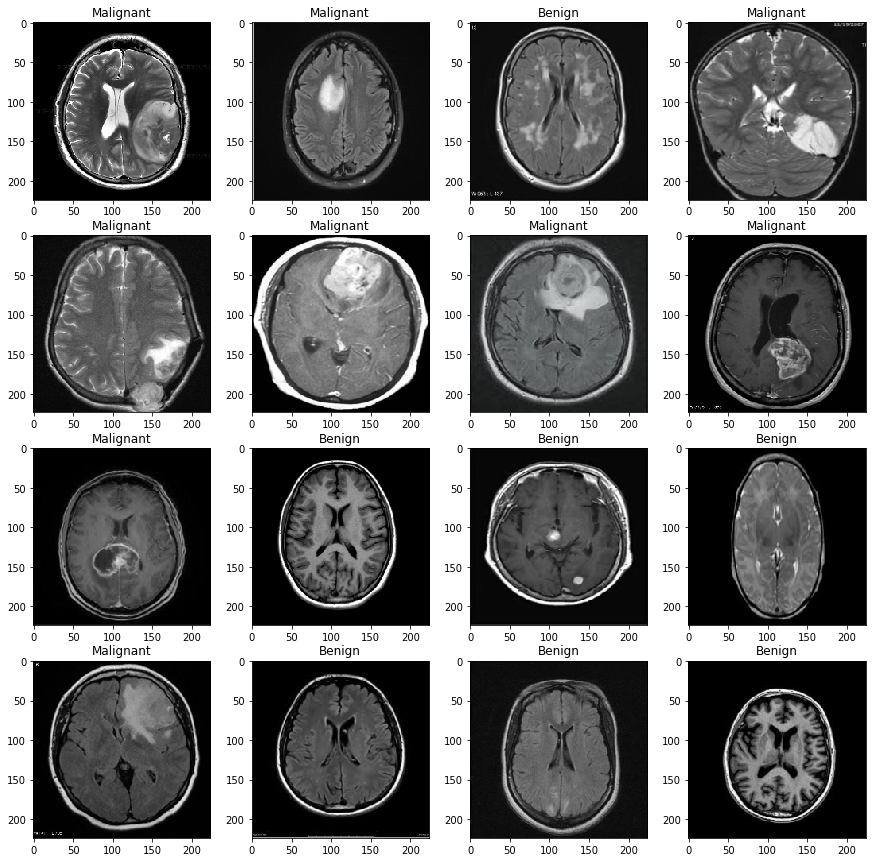

In [7]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 4

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

## CNN Model

Here, I am using pretrained ResNet Architecture trained on imagenet data (Transfer Learning). The last layers of ResNet are removed and custom trainable layers are added. The model is compiled and the summary is printed as well. 

In [8]:
K.clear_session() # Clearning the session i.e. any previously pre defined variables

model = Sequential() # Defining a sequntial model

densenet = ResNet50( # Defninng our model
    weights='imagenet', #using the pretrained weights of image net competition
    include_top=False, #not including the outer layer of imported model
    input_shape=(224,224,3) # input image shape of model
)

model.add(densenet) # adding the 'backbone' model as the first layer
model.add(layers.GlobalAveragePooling2D()) # global average pooling layer
model.add(layers.Dropout(0.5)) # Adding 50% dropout rate
model.add(layers.BatchNormalization()) # Batch normalization
model.add(layers.Dense(2, activation='softmax')) # Output layer, using softmax activations
    
model.compile( # compiling the model
        loss='binary_crossentropy', # Using the cross entropy loss, 
        optimizer=Adam(lr=lr), # using adam optimizer
        metrics=['accuracy'] # using the accuracy metric
    )

model.summary() # printing out all the layers info

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,600,002
Trainable params: 23,542,786
Non-trainable params: 57,216
_________________________________________________________________


### Model Training 
Now, the model is trained on the training set as follows:

In [9]:
# Fitting the model to the trainig set
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, validation_data=(x_test, y_test), epochs=epochs)

Epoch 1/10
9/9 [==============================] - 11s 484ms/step - loss: 0.6875 - accuracy: 0.6951 - val_loss: 0.5953 - val_accuracy: 0.6571
Epoch 2/10
9/9 [==============================] - 2s 236ms/step - loss: 0.2805 - accuracy: 0.9375 - val_loss: 0.5229 - val_accuracy: 0.7429
Epoch 3/10
9/9 [==============================] - 2s 237ms/step - loss: 0.0907 - accuracy: 0.9887 - val_loss: 0.5156 - val_accuracy: 0.7714
Epoch 4/10
9/9 [==============================] - 2s 238ms/step - loss: 0.0572 - accuracy: 0.9878 - val_loss: 0.5473 - val_accuracy: 0.7429
Epoch 5/10
9/9 [==============================] - 2s 237ms/step - loss: 0.0279 - accuracy: 0.9985 - val_loss: 0.5601 - val_accuracy: 0.7714
Epoch 6/10
9/9 [==============================] - 2s 237ms/step - loss: 0.0361 - accuracy: 0.9958 - val_loss: 0.6006 - val_accuracy: 0.8000
Epoch 7/10
9/9 [==============================] - 2s 237ms/step - loss: 0.0165 - accuracy: 1.0000 - val_loss: 0.6673 - val_accuracy: 0.7714
Epoch 8/10
9/9 [===

### Plotting accuracy curves


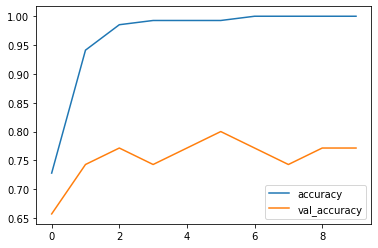

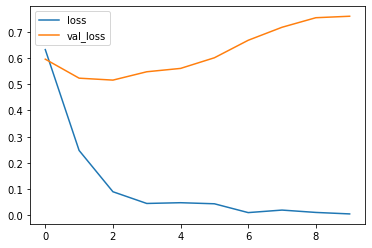

In [10]:
# Converting the 'history' list to a python pandas dataframe
history_df = pd.DataFrame(history.history)

# Plotting the accuracy curve

history_df[['accuracy', 'val_accuracy']].plot()

# Plotting the loss curve

history_df[['loss', 'val_loss']].plot()

### Model Evaluation

The model is evaluated on the test set and the achieved accuracy is as follows:

In [11]:
# Predicting the label/classes of x_test dataset using the trainined model
Y_pred = model.predict(x_test)


In [12]:
# Getting the test accuract by comparing the original label and the predicted label
acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(Y_pred, axis=1))

print("Test Accuracy (%) : ", acc*100)

Test Accuracy (%) :  77.14285714285715


### Classification Report

The classification metrics (Precision, recall, f1-score) are as follows:

In [15]:
#Printing the classification report, 

from sklearn.metrics import classification_report
print(classification_report( np.argmax(y_test, axis=1), np.argmax(Y_pred, axis=1), target_names = ["BENIGN TUMOR", "MALIGN TUMOR"]))

              precision    recall  f1-score   support

BENIGN TUMOR       0.70      0.88      0.78        16
MALIGN TUMOR       0.87      0.68      0.76        19

    accuracy                           0.77        35
   macro avg       0.78      0.78      0.77        35
weighted avg       0.79      0.77      0.77        35



## Conclusion 

We can see that our model was able to successfully classify tumor images into benign and malign categories. The f1 score for benign tumor was 0.78 and for malign tumor, it was 0.76. Also, the testing accuracy was 77.14%